# Model 1: Conv1D with token embeddings

In [28]:
# Import Libraries

import os
import pickle
import pandas as pd
from helper_functions import calculate_results
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
import random

In [2]:
# Import cleaned Dataset

#clean_dir = '/content/Data/Cleaned_dataset/'
clean_dir = '/content/'

train_df = pd.read_csv(clean_dir + 'train.csv',index_col=False)
val_df = pd.read_csv(clean_dir + 'val.csv',index_col=False)
test_df = pd.read_csv(clean_dir + 'test.csv',index_col=False)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [3]:
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [4]:
# View first 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [5]:
# One hot encoding labels

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [29]:
# Extract labels ("target" columns) and encode them into integers

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [6]:
# How long is each sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

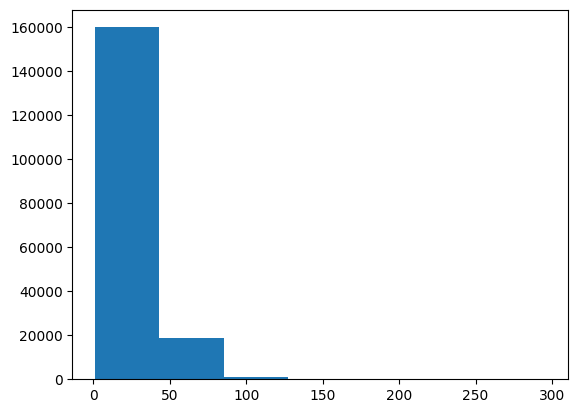

In [7]:
# What's the distribution look like?

plt.hist(sent_lens, bins=7);

In [8]:
# How long of a sentence covers 95% of the lengths?

output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [9]:
# Maximum sentence length in the training set

max(sent_lens)

296

In [10]:
# How many words are in our vocabulary?

max_tokens = 68000

In [11]:
# Create text vectorizer

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [12]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [13]:
# Test out text vectorizer

target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
further studies may validate the exploratory finding of a low-risk luminal a group who may be spared breast rt. .

Length of text: 20

Vectorized text:
[[  298   202    91  3864     2  1600  2036     4     8  3906  6780     8
     13    67    91    36 16532   413  1095     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [14]:
# How many words in our training vocabulary?

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [15]:
# Get the config of our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [16]:
# Create token embedding layer

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")


In [17]:
#  example embedding

print(f"Sentence before vectorization:\n{target_sentence}\n")

vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")

embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
further studies may validate the exploratory finding of a low-risk luminal a group who may be spared breast rt. .

Sentence after vectorization (before embedding):
[[  298   202    91  3864     2  1600  2036     4     8  3906  6780     8
     13    67    91    36 16532   413  1095     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.00532085  0.04179091  0.02862107 ... -0.03499273  0.04672981
   -0.04590433]
  [ 0.0492064  -0.00876459 -0.00926697 ... -0.04818885  0.02292167
   -0.03767021]
  [ 0.00476466 -0.01880169 -0.0362126  ...  0.04347893  0.00593051
   -0.02652243]
  ...
  [-0.03161571  0.02424521  0.04636587 ... -0.03086058  0.00149611
    0.02025583]
  [-0.03161571  0.02424521  0.04636587 ... -0.03086058  0.00149611
    0.02025583]
  [-0.03161571 

In [18]:
# Turn our data into TensorFlow Datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [19]:
# Take the TensorSliceDataset's and turn them into prefetched batches

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [21]:
# Create 1D convolutional model to process sequences

num_classes=5

inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile

model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                             

In [23]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 28s 33ms/step - loss: 0.9094 - accuracy: 0.6410 - val_loss: 0.6802 - val_accuracy: 0.7414
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.6560 - accuracy: 0.7567 - val_loss: 0.6254 - val_accuracy: 0.7706
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6150 - accuracy: 0.7745 - val_loss: 0.5951 - val_accuracy: 0.7829


In [24]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5971 - accuracy: 0.7866


[0.5970621705055237, 0.7865749001502991]

In [25]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.45231557e-01, 1.39167577e-01, 8.01527649e-02, 3.06014746e-01,
        2.94333566e-02],
       [4.31258321e-01, 2.91200399e-01, 1.42763145e-02, 2.54075825e-01,
        9.18912981e-03],
       [1.83695078e-01, 8.91377218e-03, 1.84912398e-03, 8.05483878e-01,
        5.81651802e-05],
       ...,
       [5.54957433e-06, 5.13028062e-04, 4.81519906e-04, 2.56451312e-06,
        9.98997390e-01],
       [6.10042028e-02, 4.60592955e-01, 1.25238225e-01, 6.69592842e-02,
        2.86205262e-01],
       [1.32103428e-01, 7.14331269e-01, 4.23155539e-02, 4.19402495e-02,
        6.93095848e-02]], dtype=float32)

In [26]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [30]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.65748709122204,
 'precision': 0.7834225167759232,
 'recall': 0.7865748709122203,
 'f1': 0.7841395514542336}

In [32]:
# Export results for later comparison

with open('/content/model_1_results.pickle', 'wb') as f:
    pickle.dump(model_1_results, f)


<Axes: >

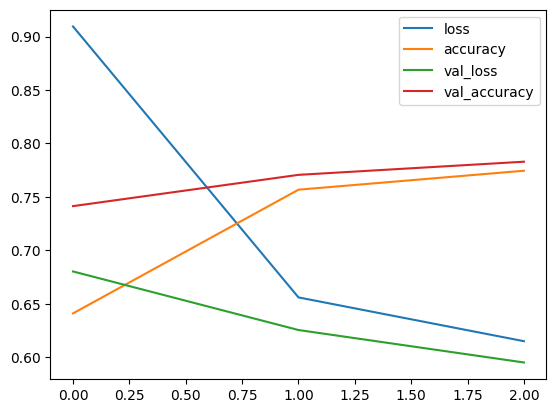

In [34]:
pd.DataFrame(model_1_history.history).plot()